# Main objective

A proper of management of power consumption and supply is important aspect of electric power industry. Main objective of this project is to develop a model that supports business requirement, which, based on several conversations with executive management is to accurately forecast next 30 days of power consumption, based on the given historical data. 

It has been decided to explore different modelling approaches, focusing on Time Series and also Deep Learning solutions to develop most accurate model.


# Brief Dataset description

The project is based on Individual household electric power consumption dataset which has been obtained from UC Irvine Machine Learning repository. Per description included on UCI platform, data includes results of measurement of electric power consumption in one household located in Sceaux (near Paris in France) for nearly 4 years. Observations were recorded every minute.

The dataset consist of nine variables, including:
* Date and time
* Global Active Power, Global Reactive Power (in kilowatt), Voltage (in volt), Global Intensity (in ampere)
* Three sub-metering areas, relevant to specific rooms devices (in watt-hour of active energy)


# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm

from datetime import datetime

import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller


from pmdarima.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import itertools

##DL##
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error



In [2]:
#df = pd.read_csv('Tetuan City power consumption.csv')
df = pd.read_csv('household_power_consumption.csv', delimiter=';', 
                 parse_dates={'DateTime' : ['Date', 'Time']}, 
                 infer_datetime_format=True, 
                 low_memory=False, 
                 na_values=['nan','?'], 
                 index_col='DateTime')

In [3]:
df.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


Blank values have been replaced by synthetically generated values accordingly to linear interpolation.

In [5]:
df = df.fillna(df.interpolate(method='linear'))
#df = df.fillna(df.median())

# Exploratory Data Analysis

For current project purpose, this research has been limited to Date and Time variables and Global Active Power as target variable

In [6]:
data = df['Global_active_power']

The power consumption included in the data set was measured between December 2006 and November 2011, recorded every minute. For the purpose of EDA, and further predictive modeling, data have been resampled to days and months.

<AxesSubplot:title={'center':'Global_active_power'}, xlabel='DateTime'>

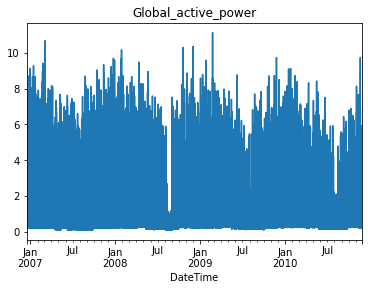

In [7]:
data.plot(title="Global_active_power")

In [8]:
consumption_daily = data.resample('D').sum()
consumption_monthly = data.resample('M').sum()
#consumption_daily = data.resample('W').sum()
consumption_daily_df = df[['Global_active_power']].resample('d').sum()

In [9]:
consumption_daily_df.describe()

,Global_active_power
count,1442.000000
mean,1569.079348
std,601.879575
min,250.298000
25%,1168.101000
50%,1549.344000
75%,1900.137000
max,4773.386000


Text(0.5, 1.0, 'Daily Global active power consumption')

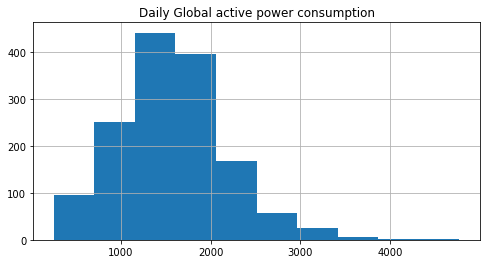

In [10]:
plt.rcParams['figure.figsize'] = [8, 4]
consumption_daily_df['Global_active_power'].hist()
plt.title('Daily Global active power consumption')

<AxesSubplot:title={'center':'Global active power consumption per day'}, xlabel='DateTime'>

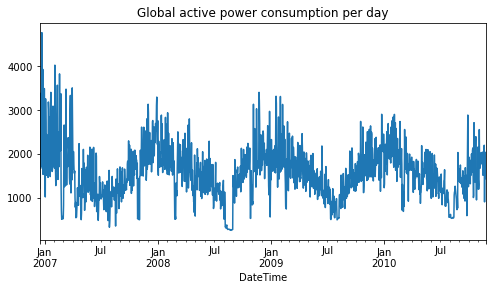

In [11]:
consumption_daily.plot(title="Global active power consumption per day")

It was identified, that the time series has strong annual, and also some weekly seasonality.

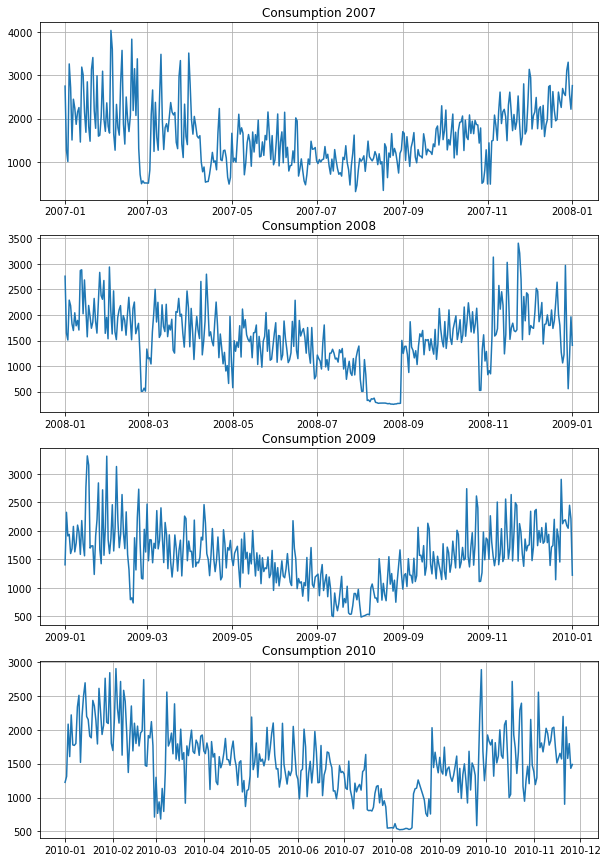

In [12]:
figs,ax =  plt.subplots(4, figsize=(10,15))

ax[0].plot(consumption_daily['2007-01-01':'2008-01-01'])
ax[0].set_title('Consumption 2007')
ax[0].grid(True)
ax[1].plot(consumption_daily['2008-01-01':'2009-01-01'])
ax[1].set_title('Consumption 2008')
ax[1].grid(True)
ax[2].plot(consumption_daily['2009-01-01':'2010-01-01'])
ax[2].set_title('Consumption 2009')
ax[2].grid(True)
ax[3].plot(consumption_daily['2010-01-01':'2011-01-01'])
ax[3].set_title('Consumption 2010')
ax[3].grid(True)

plt.show()


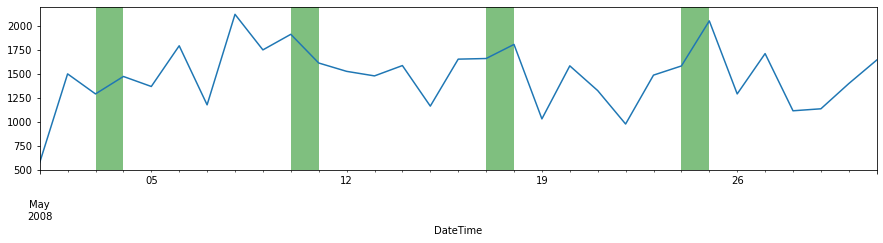

In [13]:
fig, ax =  plt.subplots(1, figsize=(15,3))
consumption_daily['2008-05-1':'2008-05-31'].plot()

plt.axvspan(pd.to_datetime('2008-05-03'),pd.to_datetime('2008-05-04'),facecolor='green', edgecolor='none', alpha=.5)
plt.axvspan(pd.to_datetime('2008-05-10'),pd.to_datetime('2008-05-11'),facecolor='green', edgecolor='none', alpha=.5)
plt.axvspan(pd.to_datetime('2008-05-17'),pd.to_datetime('2008-05-18'),facecolor='green', edgecolor='none', alpha=.5)
plt.axvspan(pd.to_datetime('2008-05-24'),pd.to_datetime('2008-05-25'),facecolor='green', edgecolor='none', alpha=.5)

plt.show()

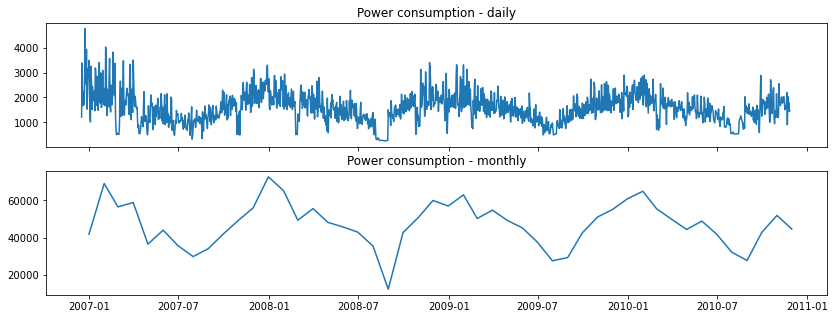

In [14]:
plt.rcParams['figure.figsize'] = [14, 5]
fig, axes = plt.subplots(2,1, sharex=True)
axes[0].plot(consumption_daily)
axes[0].title.set_text('Power consumption - daily')
axes[1].plot(consumption_monthly)
axes[1].title.set_text('Power consumption - monthly')


<AxesSubplot:title={'center':'Time series log'}, xlabel='DateTime'>

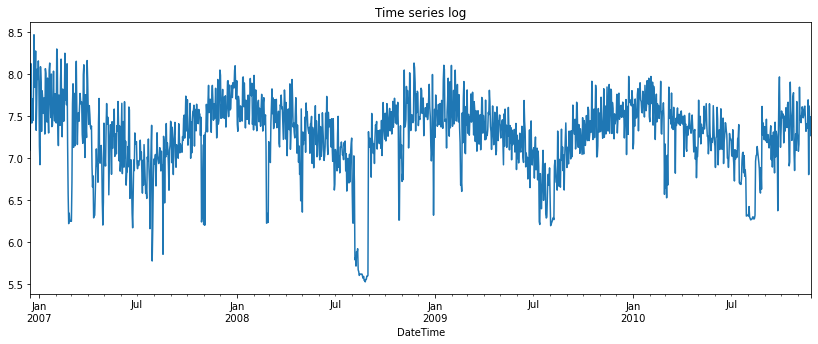

In [15]:
consumption_daily_log = np.log1p(consumption_daily)
consumption_daily_log.plot(title="Time series log")

<AxesSubplot:title={'center':'Time series differenced'}, xlabel='DateTime'>

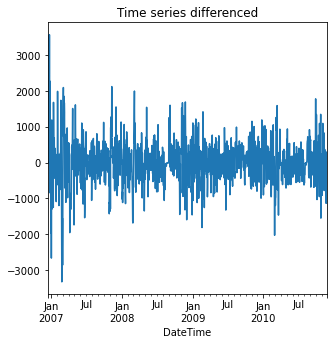

In [16]:
plt.rcParams['figure.figsize'] = [5, 5]
consumption_daily_diff = consumption_daily.diff(7).fillna(0)
consumption_daily_diff.plot(title="Time series differenced")

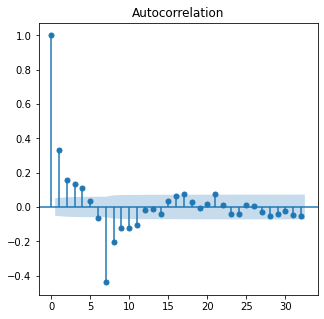

In [17]:
plot_acf(consumption_daily_diff)
plt.show()

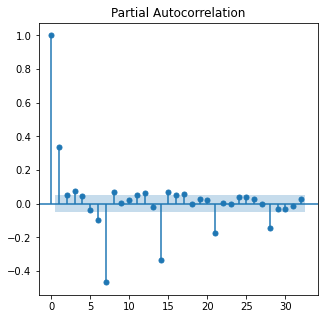

In [18]:
plot_pacf(consumption_daily_diff)
plt.show()

## Augmented Dickey-Fuller (ADF) Test

To investigate stationarity of the time series, Augmented Dickey-Fuller (ADF) test has been performed on daily power consumption data. For ADF test measurement result was -3.7102, and the p-value was 0.004, which suggest, the data is stationary in the long term, however, for modeling, seasonal decomposition has been applied to the 1 year sample (2009) of the time series.

In [19]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(consumption_daily)

In [20]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary

def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)


Test Statistic            -3.710172
p-value                    0.003972
Lags Used                 22.000000
Observations Used       1419.000000
Critical Value (1%)       -3.434967
Critical Value (5%)       -2.863579
Critical Value (10%)      -2.567856
dtype: float64


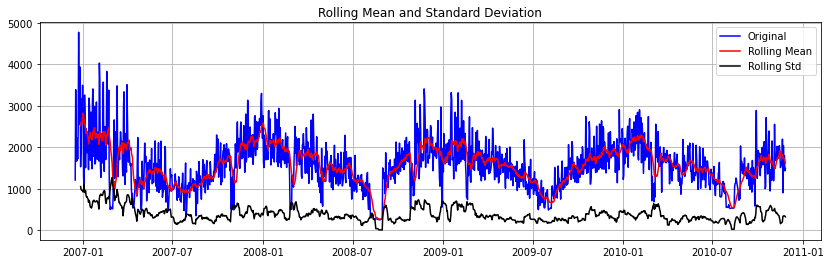

In [21]:
plt.rcParams['figure.figsize'] = [14, 4]
dftest(consumption_daily)

Test Statistic         -1.046702e+01
p-value                 1.313698e-18
Lags Used               2.000000e+01
Observations Used       1.421000e+03
Critical Value (1%)    -3.434960e+00
Critical Value (5%)    -2.863576e+00
Critical Value (10%)   -2.567854e+00
dtype: float64


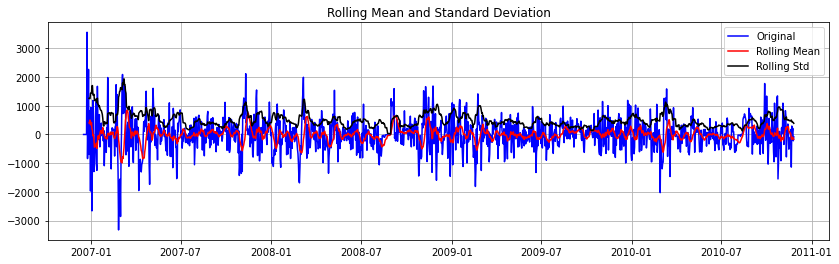

In [22]:
dftest(consumption_daily_diff.fillna(0))

In [23]:
print(adf)

-3.7101723628428958


In [24]:
print(pvalue)

0.003972324732920416


## Seasonal decomposition

In [25]:
ss_decomposition = seasonal_decompose(x=consumption_daily.loc['2009-1-1':'2009-12-31'], model='mutliplicative',period=7)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


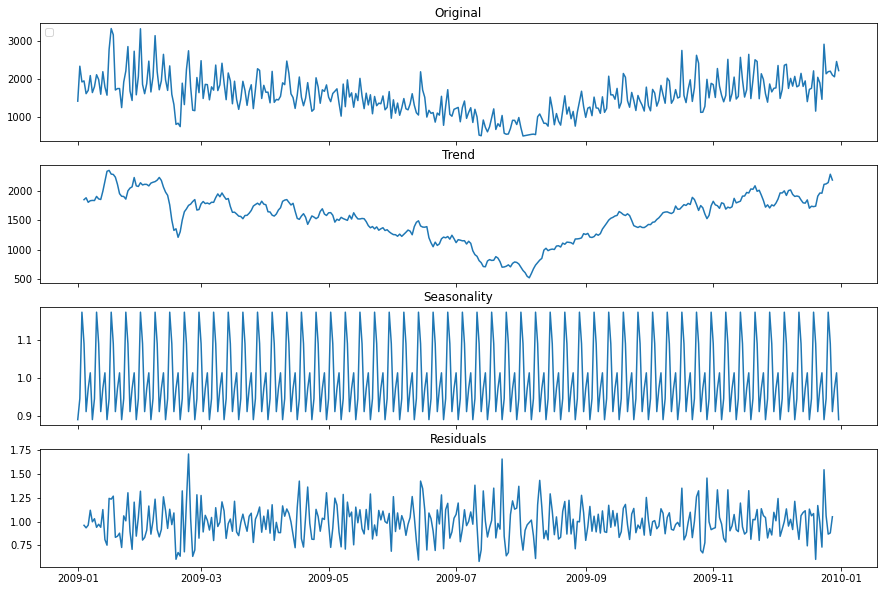

In [26]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(4,1, sharex=True)

axes[0].plot(consumption_daily.loc['2009-1-1':'2009-12-31'])
axes[0].title.set_text('Original')
axes[0].legend(loc='upper left');
axes[1].plot(estimated_trend)
axes[1].title.set_text('Trend')
axes[2].plot(estimated_seasonal)
axes[2].title.set_text('Seasonality')
axes[3].plot(estimated_residual)
axes[3].title.set_text('Residuals')


In [27]:
consumption_daily.shape

(1442,)

In [28]:
# define helper plot function for visualization
def plots(data, lags=None):
    layout = (1, 2)
    #raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 0))
    pacf = plt.subplot2grid(layout, (0, 1))
    
    #raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


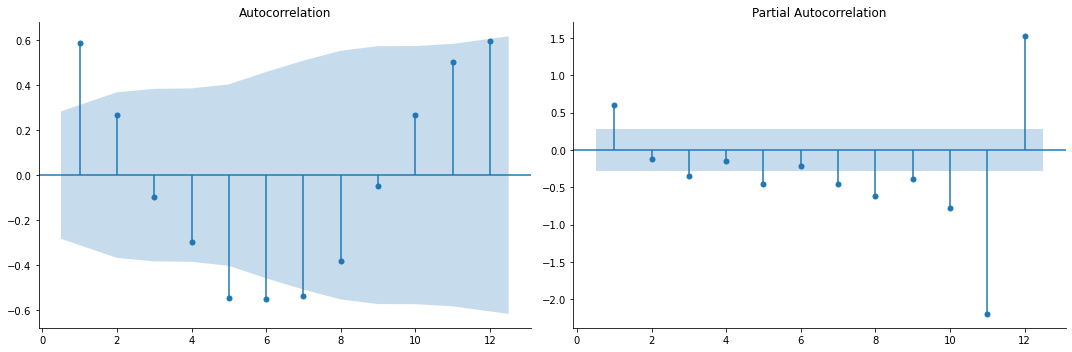

In [29]:
plt.rcParams['figure.figsize'] = [15, 5]
plots(consumption_monthly, lags=12);

# Modeling

It has been decided to develop 3 instances of standard Time series models with one additional Deep learning model. The key assumption, applicable to each model was to use the same evaluation data, therefore 1422 individual observations (days) have been split into training and test set. As the main objective was to test models’ prediction accuracy for the following 30 days, forecasted values has been compared to the actual values.

As a validation metric, Mean Absolute Percentage Error metrics (MAPE) was introduced:


$\large MAPE = \frac{100\%}{n}\ \sum\limits_{t=1}^n \left|\frac{A_t-F_t}{A_t} \right|$

Where $A_t$ is the actual value, $F_t$ is the forecast value.

The models developed are as per the following:

* Model A – ARIMA model, with parameters: p = 7, d = 1 and q = 7
* Model B – SARIMAX model, with parameters optimized by Grid Search approach
* Model C – Based on default Facebook Prophet algorithm
* Model D – Long Short-Term Memory (LSTM) Deep Learning model


In [30]:
def mape(df):
    return abs(df.actual - df.fcst).sum() / df.actual.sum()

## Model A: ARIMA

In [31]:
FOR_NUM = 30
TRAIN_NUM = consumption_daily_log.shape[0]-FOR_NUM

train, test = train_test_split(consumption_daily_log, train_size=TRAIN_NUM)


In [32]:
arima = ARIMA(train, order=(7,1,7)).fit()
arima.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                 1412
Model:                  ARIMA(7, 1, 7)   Log Likelihood                -184.220
Date:                 Wed, 06 Jul 2022   AIC                            398.440
Time:                         21:01:07   BIC                            477.221
Sample:                     12-16-2006   HQIC                           427.879
                          - 10-27-2010                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3337      0.089     -3.764      0.000      -0.507      -0.160
ar.L2         -0.2455      0.083     -2.963      0.003      -0.408      -0.083
ar.L3         -0.0555      0.098     -0.566      0.571      -0.248       0.137
ar.L4         -0.0817      0.097     -0.844      0.399      -0.272       0.108
ar.L5         -0.2895      0.079     -3.685      0.000      -0.443      -0.136
ar.L6         -0.3690      0.091     -4.073      0.000      -0.547      -0.191
ar.L7          0.4103      0.040     10.294      0.000       0.332       0.488
ma.L1         -0.1660      0.088     -1.880      0.060      -0.339       0.007
ma.L2         -0.0962      0.095     -1.009      0.313      -0.283       0.091
ma.L3         -0.1496      0.097     -1.538      0.124      -0.340       0.041
ma.L4          0.0629      0.102      0.615      0.539      -0.138       0.264
ma.L5          0.2225      0.086      2.572      0.010       0.053       0.392
ma.L6          0.2284      0.095      2.416      0.016       0.043       0.414
ma.L7         -0.6495      0.069     -9.435      0.000      -0.784      -0.515
sigma2         0.0759      0.002     36.635      0.000       0.072       0.080
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               414.97
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
forecasts = arima.predict(start=(TRAIN_NUM), end=(TRAIN_NUM + FOR_NUM-1))  # predict N steps into the future

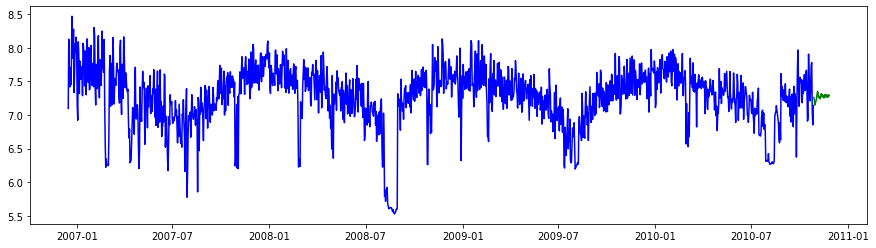

In [34]:
plt.rcParams['figure.figsize'] = [15, 4]

# Visualize the forecasts (blue=train, green=forecasts)
x = consumption_daily_log.index
plt.plot(x[:TRAIN_NUM], train, c='blue')
plt.plot(x[TRAIN_NUM:], forecasts, c='green')
#plt.show()

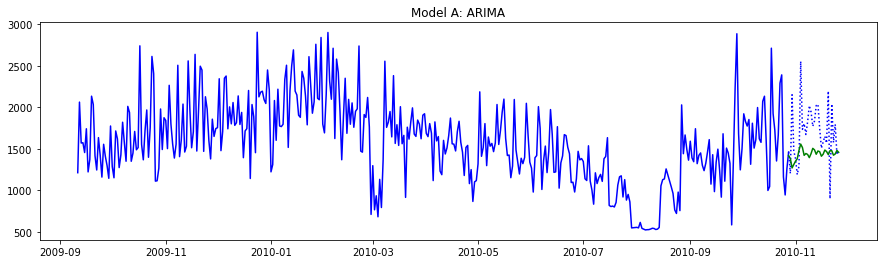

In [35]:
plt.plot(x[1000:TRAIN_NUM+1], consumption_daily[1000:TRAIN_NUM+1], c='blue')
plt.plot(x[TRAIN_NUM:], consumption_daily[TRAIN_NUM:], c='blue', linestyle='dotted')
plt.plot(x[TRAIN_NUM:], np.exp(forecasts), c='green')
plt.title('Model A: ARIMA')
plt.show()

In [36]:
actual = consumption_daily[TRAIN_NUM:]

In [37]:
output_df_0 = pd.DataFrame(actual)
output_df_0 = output_df_0.rename({'Global_active_power':'actual'}, axis=1)
output_df_0['fcst'] = np.exp(forecasts).tolist()
output_df_0

,actual,fcst
DateTime,,
2010-10-28,1463.326,1420.262131
2010-10-29,1204.422,1383.130762
2010-10-30,2152.700,1270.990131
2010-10-31,1476.430,1312.491647
2010-11-01,1383.180,1352.753800
2010-11-02,1191.082,1381.844077
2010-11-03,1293.298,1482.649226
2010-11-04,2555.146,1558.567864
2010-11-05,1736.088,1517.695511


In [38]:
mape(output_df_0)

0.1979520730426913

<AxesSubplot:xlabel='DateTime'>

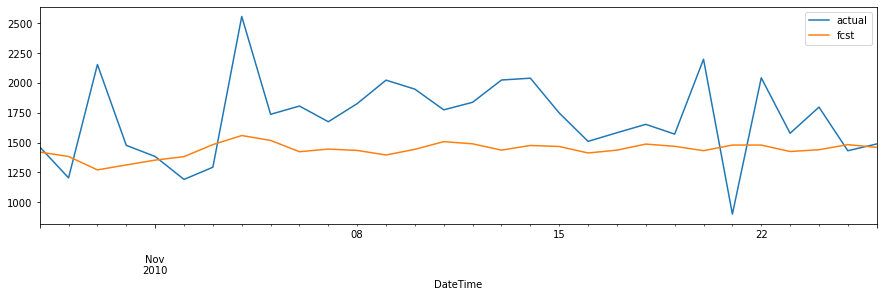

In [39]:
output_df_0.plot()

## Model B: AUTOARIMA

In [40]:
def sarimax(series,all_param): #
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(series,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results

In [41]:
# set parameter range
p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[7]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

all_res = sarimax(train,all_param)

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 7) - AIC:1631.81
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 7) - AIC:764.27
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 7) - AIC:766.27
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 7) - AIC:1236.65
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 7) - AIC:766.27
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 7) - AIC:768.19
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 7) - AIC:1041.06
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 7) - AIC:768.27
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 7) - AIC:769.96
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:1393.27
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 7) - AIC:469.57
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 7) - AIC:469.66
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 7) - AIC:963.91
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 7) - AIC:469.63
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 7) - AIC:471.62
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 7) - AIC:756.23
Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 7) - AIC:471.59
Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 7) - AIC:473.21
Tried out SARIMAX(0, 1, 2)x(0, 1, 0, 7) - 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(1, 1, 0, 7) - AIC:852.42
Tried out SARIMAX(1, 1, 2)x(1, 1, 1, 7) - AIC:439.83


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(1, 1, 2, 7) - AIC:441.83


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(2, 1, 0, 7) - AIC:676.92
Tried out SARIMAX(1, 1, 2)x(2, 1, 1, 7) - AIC:441.8


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(1, 1, 2)x(2, 1, 2, 7) - AIC:443.5
Tried out SARIMAX(2, 1, 0)x(0, 1, 0, 7) - AIC:1423.81
Tried out SARIMAX(2, 1, 0)x(0, 1, 1, 7) - AIC:512.03
Tried out SARIMAX(2, 1, 0)x(0, 1, 2, 7) - AIC:513.4
Tried out SARIMAX(2, 1, 0)x(1, 1, 0, 7) - AIC:1005.98
Tried out SARIMAX(2, 1, 0)x(1, 1, 1, 7) - AIC:513.39
Tried out SARIMAX(2, 1, 0)x(1, 1, 2, 7) - AIC:515.9
Tried out SARIMAX(2, 1, 0)x(2, 1, 0, 7) - AIC:804.22
Tried out SARIMAX(2, 1, 0)x(2, 1, 1, 7) - AIC:515.34
Tried out SARIMAX(2, 1, 0)x(2, 1, 2, 7) - AIC:517.27
Tried out SARIMAX(2, 1, 1)x(0, 1, 0, 7) - AIC:1215.33
Tried out SARIMAX(2, 1, 1)x(0, 1, 1, 7) - AIC:439.12
Tried out SARIMAX(2, 1, 1)x(0, 1, 2, 7) - AIC:440.0
Tried out SARIMAX(2, 1, 1)x(1, 1, 0, 7) - AIC:864.12
Tried out SARIMAX(2, 1, 1)x(1, 1, 1, 7) - AIC:439.98
Tried out SARIMAX(2, 1, 1)x(1, 1, 2, 7) - AIC:442.9
Tried out SARIMAX(2, 1, 1)x(2, 1, 0, 7) - AIC:698.96


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 1)x(2, 1, 1, 7) - AIC:441.95


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 1)x(2, 1, 2, 7) - AIC:443.66
Tried out SARIMAX(2, 1, 2)x(0, 1, 0, 7) - AIC:1189.89
Tried out SARIMAX(2, 1, 2)x(0, 1, 1, 7) - AIC:440.9
Tried out SARIMAX(2, 1, 2)x(0, 1, 2, 7) - AIC:441.85
Tried out SARIMAX(2, 1, 2)x(1, 1, 0, 7) - AIC:874.16
Tried out SARIMAX(2, 1, 2)x(1, 1, 1, 7) - AIC:441.83


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 2)x(1, 1, 2, 7) - AIC:444.7
Tried out SARIMAX(2, 1, 2)x(2, 1, 0, 7) - AIC:734.04
Tried out SARIMAX(2, 1, 2)x(2, 1, 1, 7) - AIC:443.79


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tried out SARIMAX(2, 1, 2)x(2, 1, 2, 7) - AIC:445.55


In [42]:
all_res.sort(key=lambda x: x[1])
all_res[:5]
model = all_res[0][0]

In [43]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:               Global_active_power   No. Observations:                 1412
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood                -214.699
Date:                           Wed, 06 Jul 2022   AIC                            437.398
Time:                                   21:03:06   BIC                            458.386
Sample:                               12-16-2006   HQIC                           445.243
                                    - 10-27-2010                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2822      0.030      9.541      0.000       0.224       0.340
ma.L1         -0.7803      0.021    -37.138      0.000      -0.821      -0.739
ma.S.L7       -0.9546      0.010   -100.087      0.000      -0.973      -0.936
sigma2         0.0785      0.002     43.222      0.000       0.075       0.082
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               757.91
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
forecasts = model.predict(start=(TRAIN_NUM), end=(TRAIN_NUM + FOR_NUM-1))

Text(0.5, 1.0, 'Model B: SARIMAX')

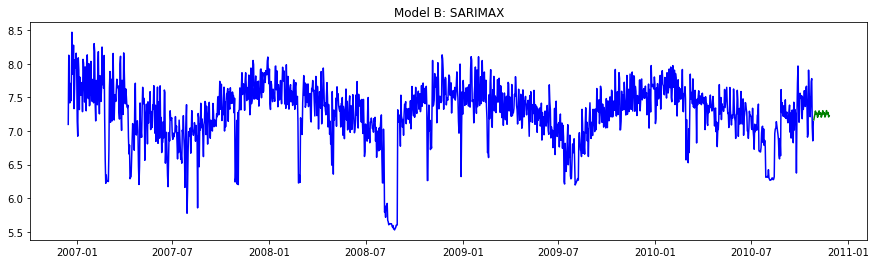

In [45]:
plt.rcParams['figure.figsize'] = [15, 4]
x = consumption_daily_log.index
plt.plot(x[:TRAIN_NUM], train, c='blue')
plt.plot(x[TRAIN_NUM:], forecasts, c='green')
plt.title('Model B: SARIMAX')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


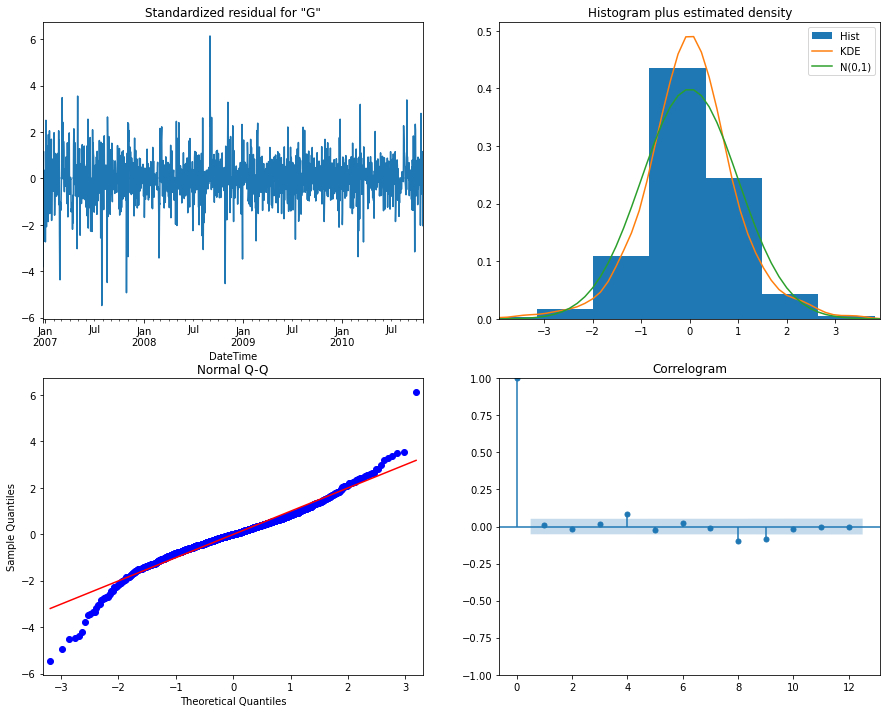

In [46]:
model.plot_diagnostics(figsize=(15, 12), lags=12)
plt.show()

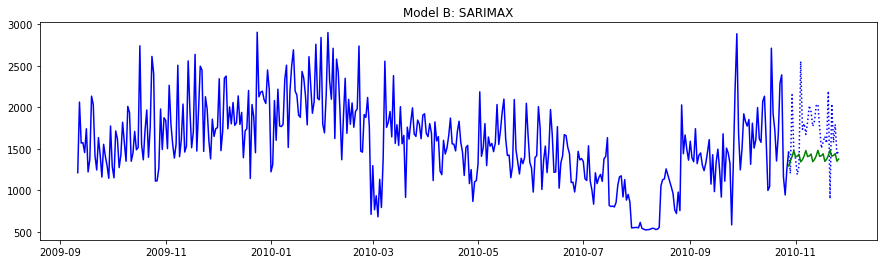

In [47]:
plt.rcParams['figure.figsize'] = [15, 4]
plt.plot(x[1000:TRAIN_NUM+1], consumption_daily[1000:TRAIN_NUM+1], c='blue')
plt.plot(x[TRAIN_NUM:], consumption_daily[TRAIN_NUM:], c='blue', linestyle='dotted')
plt.plot(x[TRAIN_NUM:], np.exp(forecasts), c='green')
plt.title('Model B: SARIMAX')
plt.show()


In [48]:
forecast = np.exp(forecasts)

In [49]:
output_df_1 = pd.DataFrame(actual)
output_df_1 = output_df_1.rename({'Global_active_power':'actual'}, axis=1)
output_df_1['fcst'] = forecast.tolist()

In [50]:
mape(output_df_1)

0.21498716664112238

<AxesSubplot:xlabel='DateTime'>

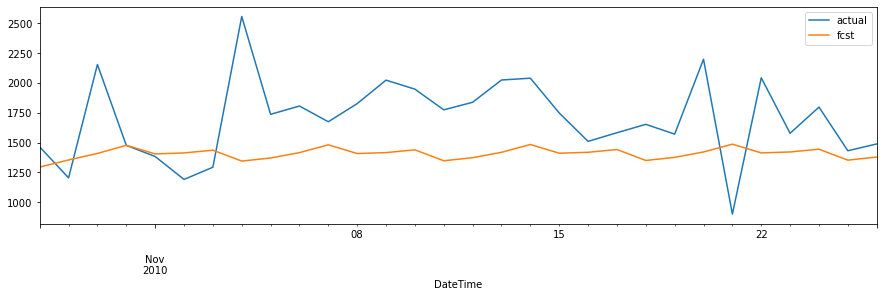

In [51]:
output_df_1.plot()

# Model C: Prophet

In [52]:
from fbprophet import Prophet
#from prophet import Prophet

In [53]:
data_b = pd.DataFrame(consumption_daily).reset_index()
data_b = data_b.rename(columns={'DateTime':'ds','Global_active_power':'y'})
data_b['y'] = np.log(data_b['y'])

In [54]:
data_b.head(5)

,ds,y
0,2006-12-16,7.097694
1,2006-12-17,8.128721
2,2006-12-18,7.697950
3,2006-12-19,7.418297
4,2006-12-20,7.707848


In [55]:
data_b.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [56]:
train_b = data_b.iloc[:TRAIN_NUM]
test_b = data_b.iloc[TRAIN_NUM:]
test_b.set_index('ds', inplace=True)

In [57]:
m = Prophet()
m.fit(train_b)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [58]:
future = m.make_future_dataframe(periods=FOR_NUM, freq='D', include_history=True)

In [59]:
# populate forecast
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
1437,2010-11-22,7.648195,7.231139,8.024473
1438,2010-11-23,7.723677,7.318399,8.130528
1439,2010-11-24,7.736083,7.308079,8.146526
1440,2010-11-25,7.633403,7.217239,8.055229
1441,2010-11-26,7.701255,7.287493,8.127706


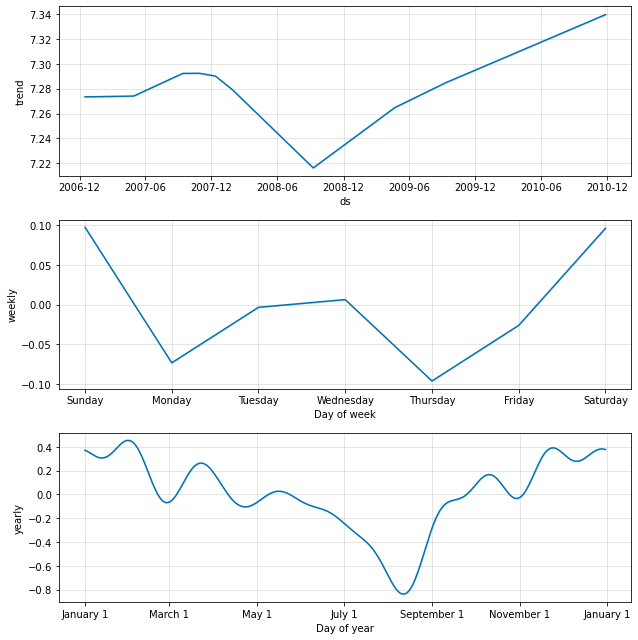

In [60]:
# plot individual components of forecast: trend, weekly/yearly seasonality,
m.plot_components(forecast);

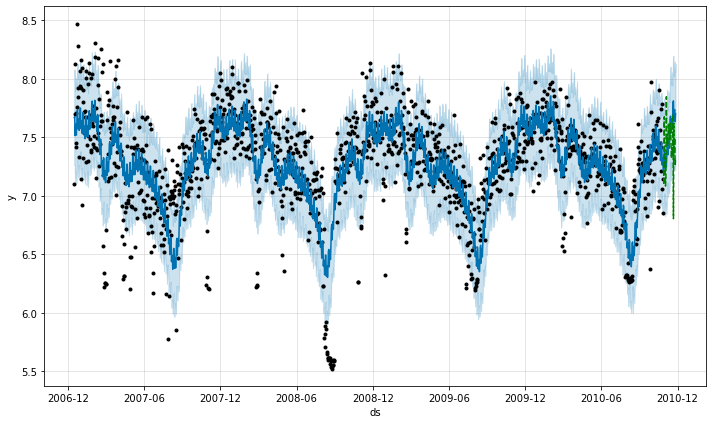

In [61]:
plt.rcParams['figure.figsize'] = [15, 4]
m.plot(forecast)
plt.plot(test_b.y, 'g--')


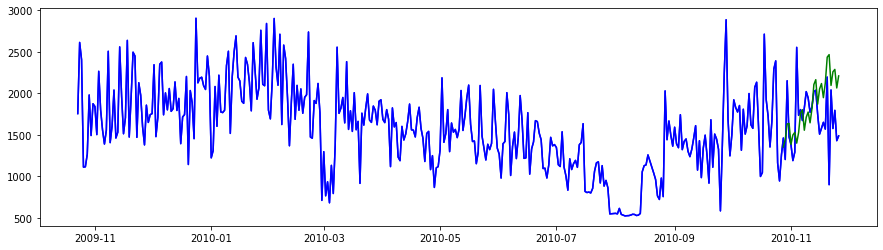

In [62]:
c = data_b.iloc[-400:]
fc = forecast.iloc[-FOR_NUM:]

plt.plot(c.ds, np.exp(c.y), 'b-')
plt.plot(c.ds, np.exp(c.y), 'b-')
plt.plot(fc.ds, np.exp(fc.yhat), 'g-')

In [67]:
output_df_2 = pd.DataFrame(test_b)
output_df_2
output_df_2 = output_df_1.rename({'y':'actual'}, axis=1)
output_df_2['fcst'] = forecast.yhat.iloc[-FOR_NUM:].tolist()
output_df_2['fcst'] = output_df_2['fcst'].apply(np.exp)

In [68]:
mape(output_df_2)

0.2098595015093189

<AxesSubplot:xlabel='DateTime'>

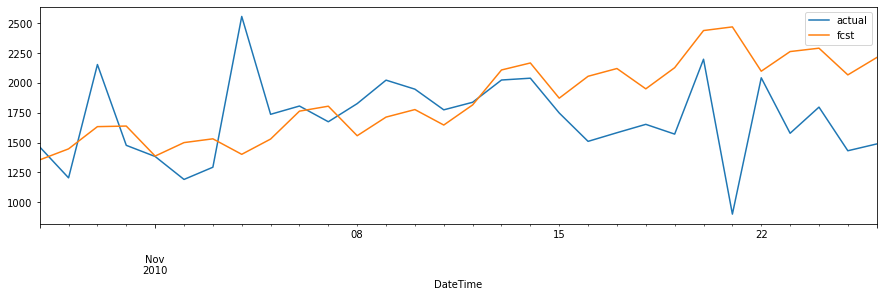

In [69]:
output_df_2.plot()

# Model D: Deep learning LSTM

In [70]:
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    return df[series_name][-(n_days):] 

def plot_n_last_days(df, series_name, n_days):
    """
    Plot last n_days of an hourly time series 
    """
    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
    plt.title('{0} Air Quality Time Series - {1} days'
              .format(series_name, n_days))
    #plt.xlabel('Recorded Hour')
    plt.xlabel('Recorded Day')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

In [71]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours, 
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

In [72]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return model

In [73]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return model

In [74]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])
    
    return y_preds

In [75]:
series_days = 1422 # 56
input_hours = FOR_NUM # 12
test_hours = FOR_NUM * 2 # 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(consumption_daily_df, 'Global_active_power', series_days, 
                         input_hours, test_hours))

In [76]:
from tensorflow import keras
model = keras.models.load_model('my_model best.h5') ## neural net previously trained as per below:
#model = fit_LSTM(train_X, train_y, cell_units=140, epochs=10000) 

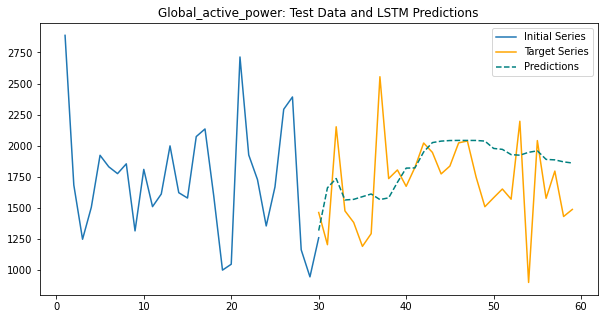

In [77]:
plt.rcParams['figure.figsize'] = [10, 5]
forecast = predict_and_plot(test_X_init, test_y, model, 
                 'Global_active_power: Test Data and LSTM Predictions')

In [78]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 140)               79520     
                                                                 
 dense_39 (Dense)            (None, 1)                 141       
                                                                 
Total params: 79,661
Trainable params: 79,661
Non-trainable params: 0
_________________________________________________________________


In [79]:
forecast = forecast.ravel()
actual = consumption_daily[-FOR_NUM:]
output_df_3 = pd.DataFrame(actual)
output_df_3 = output_df_3.rename({'Global_active_power':'actual'}, axis=1)
output_df_3['fcst'] = forecast

In [80]:
mape(output_df_3)

0.16820346470190367

In [81]:
#model.save('my_model.h5') 

<AxesSubplot:xlabel='DateTime'>

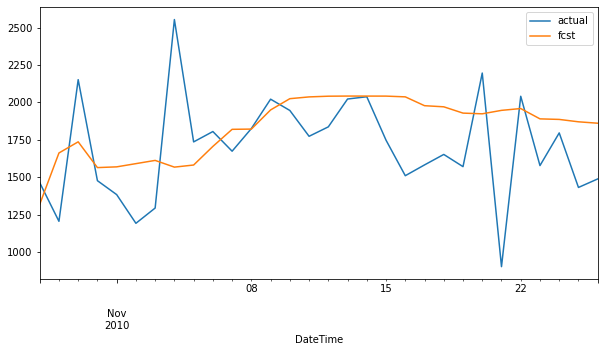

In [82]:
output_df_3.plot()

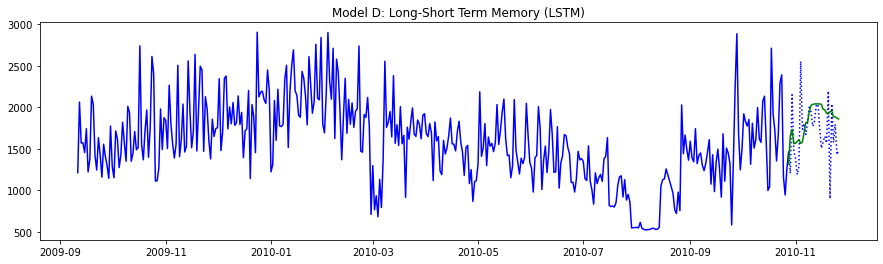

In [83]:
plt.rcParams['figure.figsize'] = [15, 4]
plt.plot(x[1000:TRAIN_NUM+1], consumption_daily[1000:TRAIN_NUM+1], c='blue')
plt.plot(x[TRAIN_NUM:], consumption_daily[TRAIN_NUM:], c='blue', linestyle='dotted')
plt.plot(x[TRAIN_NUM:], forecast, c='green')
plt.title('Model D: Long-Short Term Memory (LSTM)')
plt.show()

In [84]:
models_num_list = [str('Model ' + x) for x in 'ABCD']
models_df_list = [output_df_0, output_df_1, output_df_2, output_df_3]
mape_list = [mape(x) for x in models_df_list]
d = {'Algorithm':['ARIMA', 'SARIMAX', 'Prophet', 'LSTM'], 'MAPE': mape_list}

In [85]:
mape_df = pd.DataFrame(d, index=models_num_list)

# Recommended model

The main goal for the predictive modeling was to identify the best performing model and although the results of all 4 models were similar, the most accurate model, with Mean Absolute Percentage Error of 0.17 was model D (LSTM) and this one is recommended for implementation.

In [86]:
mape_df

,Algorithm,MAPE
Model A,ARIMA,0.197952
Model B,SARIMAX,0.214987
Model C,Prophet,0.209860
Model D,LSTM,0.168203


# Key Findings and Insights

1. All four models have fairly similar MAPE results, however looking at the individual predictions of last 30 days, ARIMA/SARIMA based models results were more consistent, comparing to Prophet and DL based model.

In [87]:
models_df = pd.DataFrame(output_df_0).rename(columns={'fcst':'forecast (Model A)'})
models_df = models_df.join(output_df_1['fcst']).rename(columns={'fcst':'forecast (Model B)'})
models_df = models_df.join(output_df_2['fcst']).rename(columns={'fcst':'forecast (Model C)'})
models_df = models_df.join(output_df_3['fcst']).rename(columns={'fcst':'forecast (Model D)'})

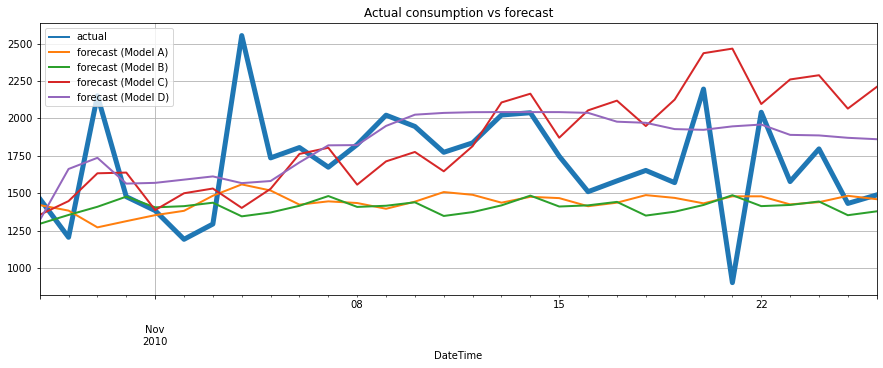

In [88]:
fig, ax = plt.subplots()
models_df.plot(figsize=(15,5), title='Actual consumption vs forecast', 
        lw=2, fontsize=10, ax=ax, grid=True)

for line in ax.get_lines():
    if line.get_label() == 'actual':
        line.set_linewidth(5)
plt.show()

2.	Deep learning model outperformed standard Time-series modeling approaches, but its disadvantage comparing to other 3 models is definitely lack of explainability, due to the nature of neural networks based solutions. Also Model D was definitely the most time-consuming model, whereas the Model C (Prophet based) require relatively small efforts to tune up the model

3.	The least accurate model’s predictions (Model B SARIMA) were relatively more stable comparing to the best performing model (Model D LSTM).

# Further recommendations 

The recommended model appears to be the most efficient one in terms of the accuracy of the prediction, however, there might be some area of improvement, such as: 
* using a different number of units in the hidden layer, 
* including additional layers,
* increasing the number of iterations when training the neural network. 

In addition to that, all developed models can be enhanced by taking into account public holidays which may have noticeable impact on the prediction.
